# Distributed Vault Final Demo

Here, we demonstrate some of the key features of our platform! To start, ensure that the rest of the files in the release are in the same folder as this notebook. The demo is intended to be ran on Google Colab through a mounted Google Drive, but it is possible for it to work on a local machine as well. Please read the set-up instructions for more information.

## Setup and imports

We use Google Colab with Python 3. We recommend that you connect to a runtime with a GPU (most of the training was done on T4). If you are on Google Colab, please mount your drive and then run the cells below to install all dependencies.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install medmnist
%pip install sentence-transformers scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a08cd6263070c7d658047956ebd843a470cb8e13981f62e97dda394d1f05a8b1
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


You should insure that you are in the directory with the remainder of the files. On our drives, this folder is `/content/drive/MyDrive/CAP_The-Federation_asj53_ctc92-main`, but it will likely be different for you, so change the command in the cell below as needed. You might see warnings about a secret 'HF_Token', ignore this as we do not use one.

In [3]:
import sys
#sys.path.append('/content/drive/MyDrive/OneFL/src')
%cd /content/drive/MyDrive/OneFL/OneFL-main/src

/content/drive/MyDrive/OneFL/OneFL-main/src


Import the following packages. Note that if you are not in the correct directory, the second half of the imports (local modules) will not import correctly.

In [4]:
import tkinter as tk
from tkinter import messagebox
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import os
from medmnist import INFO, BreastMNIST
from torchvision import transforms
import medmnist
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# these are our modules!
import semantic_search as sems
import utils
from utils import fl_partition
import fedisca
from fedisca import FedISCA
from train_loc import LocalTrainer
from resnet import ResNet18, ResNet50

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
%load_ext autoreload
%autoreload 2

## Set up federated scenario

For the demo, we set up a specific federation scenario:
- 5 clients each with a local model
- Task: classification on the pneumoniamnist dataset (binary classification)
- Data split is non-iid (dirichlet with $\beta=0.6$), so each distribution over the labels is different.

In [7]:
data_flag = 'pneumoniamnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
glb_train_dataset = DataClass(root="./", split='train', download=download)
glb_val_dataset = DataClass(root="./", split='val', download=download)
glb_test_dataset = DataClass(root="./", split='test', download=download)
info["n_samples"]["train"] = glb_train_dataset.imgs.shape[0]
info["n_samples"]["val"] = glb_val_dataset.imgs.shape[0]
info["n_samples"]["test"] = glb_test_dataset.imgs.shape[0]
glb_train_dataset

Using downloaded and verified file: ./pneumoniamnist.npz
Using downloaded and verified file: ./pneumoniamnist.npz
Using downloaded and verified file: ./pneumoniamnist.npz


Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: ./
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

Set up the partitioned dataset. This will create a folder called `pneumoniamnist_expr/sim_partitions_dirichlet` that contains subfolders 'client_0', ..., 'client_4'. Each client folder contains a unique .npz file that has a train and validation split that is a subset of the original training dataset.

In [8]:
num_clients = 5
num_classes = 2
part_dir, list_name, split_ids = utils.fl_partition(
    glb_train_dataset,
    "pneumonia",
    num_clients,
    num_classes,
    iid=False,
    beta=0.6,
    val_split=0.2,
    seed=42
    )

In [ ]:
print(part_dir)

pneumonia_expr/sim_partitions_dirichlet


We can visualize the label distribution

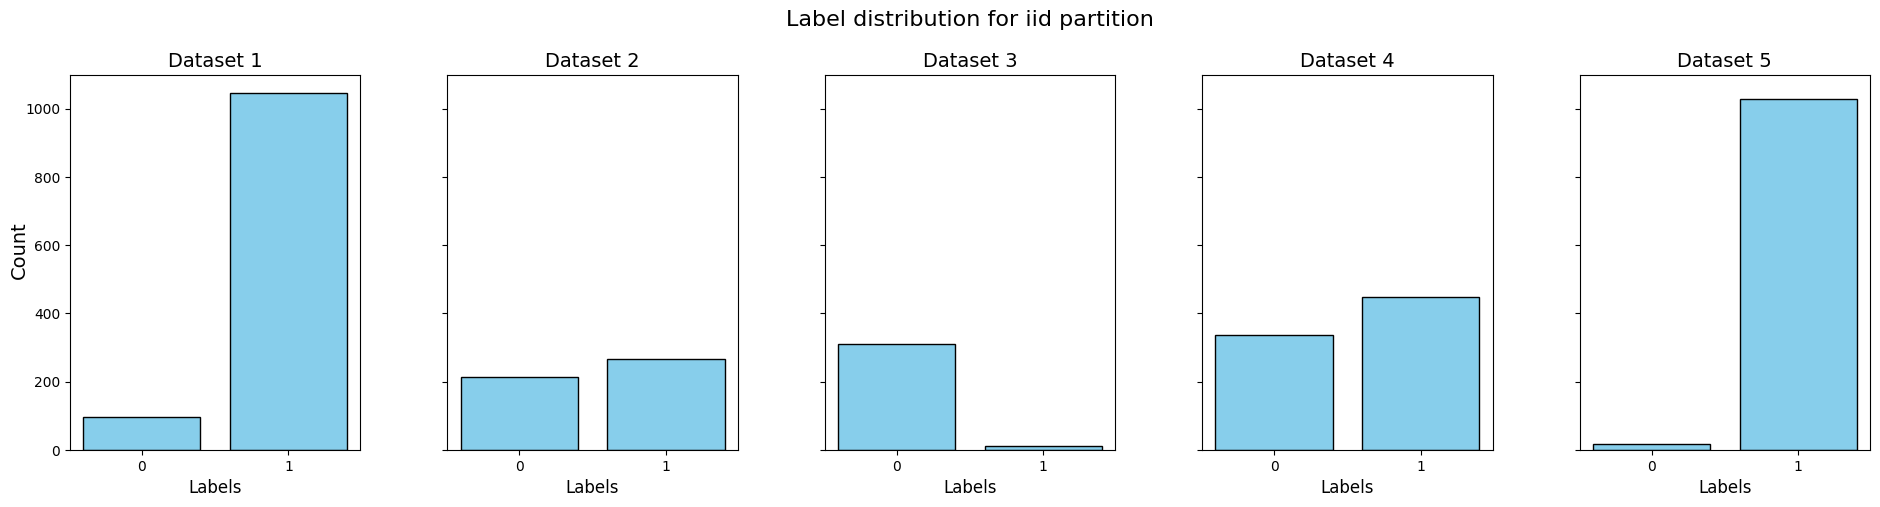

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for list_ind, ax in enumerate(axes):
    f_name = list_name[list_ind]
    data = np.load(f_name)
    labels = data['train_labels'].flatten().tolist()
    label_counts = Counter(labels)
    categories = list(label_counts.keys())
    counts = list(label_counts.values())

    # Plot on the current subplot
    ax.bar(categories, counts, color='skyblue', edgecolor='black')
    ax.set_title(f"Dataset {list_ind + 1}", fontsize=14)
    ax.set_xlabel('Labels', fontsize=12)
    ax.set_xticks(ticks=categories)
    ax.tick_params(axis='y', labelsize=10)

fig.supylabel('Count', fontsize=14)
fig.suptitle('Label distribution for iid partition', fontsize=16)
fig.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1, wspace=0.3)
#plt.tight_layout()

plt.show()

Train local model on each partitioned dataset

In [ ]:
data_flag = 'pneumoniamnist'

info = medmnist.INFO[data_flag].copy()
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

for i in range(num_clients):
    DataClass = getattr(medmnist, info['python_class'])
    root = os.path.join(part_dir, "client_" + str(i))
    train_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='train', download=False)
    val_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='val', download=False)
    info = medmnist.INFO[data_flag].copy()
    train_dataset.info = info
    val_dataset.info = info
    train_dataset.info["n_samples"]["train"] = train_dataset.imgs.shape[0]
    val_dataset.info["n_samples"]["val"] = val_dataset.imgs.shape[0]

    aug_list = []
    aug_list.append(transforms.RandomCrop(28, padding=4))
    aug_list.append(transforms.RandomHorizontalFlip())
    preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]

    loc_trainer_test = LocalTrainer(ResNet18(in_channels=1, num_classes=2), DataClass, os.path.join("pneumonia_models", "client_" + str(i)), n_classes, root=root, epochs=100, lr_adj = [50, 75], aug=aug_list, preprocess=preprocess_list, seed=i)
    loc_trainer_test.train()

Epoch num: 1 
Train loss: 0.030282 
Val loss: 0.003600 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 2 
Train loss: 0.017632 
Val loss: 0.013272 
Val acc: 0.901754
Val balanced acc: 0.500000


KeyboardInterrupt: 

This will create a folder `pneumonia_models` containing subfolders of each client's privately trained model. If you do not want to train these models yourself, we provide them as binaries with the GitHub release. Ensure that the folder containing the trained models is named `pneumonia_models` and that the subfolders are `client_0`, `client_1`, etc. Each client folder should contain a single file `best.pth` which represents the trained model.

## Training heterogenous models

In [ ]:
data_flag = 'pneumoniamnist'

info = medmnist.INFO[data_flag].copy()
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

model_types = ["ResNet18", "ResNet50", "ResNet18", "ResNet50", "ResNet50"]

for i in range(num_clients):
    DataClass = getattr(medmnist, info['python_class'])
    root = os.path.join(part_dir, "client_" + str(i))
    train_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='train', download=False)
    val_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='val', download=False)
    info = medmnist.INFO[data_flag].copy()
    train_dataset.info = info
    val_dataset.info = info
    train_dataset.info["n_samples"]["train"] = train_dataset.imgs.shape[0]
    val_dataset.info["n_samples"]["val"] = val_dataset.imgs.shape[0]

    aug_list = []
    aug_list.append(transforms.RandomCrop(28, padding=4))
    aug_list.append(transforms.RandomHorizontalFlip())
    preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]
    if model_types[i] == "ResNet18":
      loc_trainer_test = LocalTrainer(ResNet18(in_channels=1, num_classes=2), DataClass, os.path.join("pneumonia_models", "client_" + str(i)), n_classes, root=root, epochs=100, lr_adj = [50, 75], aug=aug_list, preprocess=preprocess_list, seed=i)
    elif model_types[i] == "ResNet50":
      loc_trainer_test = LocalTrainer(ResNet50(in_channels=1, num_classes=2), DataClass, os.path.join("pneumonia_models", "client_" + str(i)), n_classes, root=root, epochs=100, lr_adj = [50, 75], aug=aug_list, preprocess=preprocess_list, seed=i)
    loc_trainer_test.train()

Epoch num: 1 
Train loss: 0.033534 
Val loss: 0.004027 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 2 
Train loss: 0.021329 
Val loss: 0.005733 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 3 
Train loss: 0.014763 
Val loss: 0.012783 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 4 
Train loss: 0.010145 
Val loss: 0.008992 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 5 
Train loss: 0.009127 
Val loss: 0.001764 
Val acc: 0.947368
Val balanced acc: 0.748054
Epoch num: 6 
Train loss: 0.007544 
Val loss: 0.005786 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 7 
Train loss: 0.009066 
Val loss: 0.004566 
Val acc: 0.905263
Val balanced acc: 0.517857
Epoch num: 8 
Train loss: 0.008772 
Val loss: 0.000613 
Val acc: 0.964912
Val balanced acc: 0.948722
Epoch num: 9 
Train loss: 0.007443 
Val loss: 0.001976 
Val acc: 0.936842
Val balanced acc: 0.678571
Epoch num: 10 
Train loss: 0.006650 
Val loss: 0.001136 
Val acc: 0.954386
Val balanced acc

## Experiment with model heterogeneity

In [10]:
FedPneu_heter = fedisca.FedISCA(test_data_dir="./", model_weights_dir="./pneumonia_models", exper_dir="./pneumonia_exper/federated", input_size=28, in_channels=1, num_classes=2, batch_size=64, epochs=25, iter_mi=500, lr_steps = [15, 20], log_freq=25, is_medmnist=True, medmnist="pneumoniamnist")
models = [ResNet18(in_channels=1, num_classes=2), ResNet50(in_channels=1, num_classes=2), ResNet18(in_channels=1, num_classes=2),ResNet50(in_channels=1, num_classes=2),ResNet50(in_channels=1, num_classes=2)]
fedpneu_local = FedPneu_heter.load_models(models)

In [11]:
fed_model, noise_adapt = FedPneu_heter.model_inversion(fedpneu_local, large_jtr=5, small_jtr=2)

Generating images...
It 0	 Losses: total: 16926800.000,	target: 2.350 	R_feature_loss scaled:	 16926798.000
It 25	 Losses: total: 226802.484,	target: 1.868 	R_feature_loss scaled:	 226800.594
It 50	 Losses: total: 194629.797,	target: 1.841 	R_feature_loss scaled:	 194627.938
It 75	 Losses: total: 188554.844,	target: 1.849 	R_feature_loss scaled:	 188552.984
It 100	 Losses: total: 129710.117,	target: 1.879 	R_feature_loss scaled:	 129708.219
It 125	 Losses: total: 157994.344,	target: 1.860 	R_feature_loss scaled:	 157992.469
It 150	 Losses: total: 147361.734,	target: 1.905 	R_feature_loss scaled:	 147359.812
It 175	 Losses: total: 129466.859,	target: 1.907 	R_feature_loss scaled:	 129464.938
It 200	 Losses: total: 113909.695,	target: 1.897 	R_feature_loss scaled:	 113907.781
It 225	 Losses: total: 121169.789,	target: 1.902 	R_feature_loss scaled:	 121167.875
It 250	 Losses: total: 112131.734,	target: 1.917 	R_feature_loss scaled:	 112129.805
It 275	 Losses: total: 110072.250,	target: 1.

## Demo platform

Here, we define some functions to help combine the parts of our platform into a rough UI. Improvements coming in the future!

1. `train_resnet50_finetune` finetunes an existing model (transfer learning)
2. `federated_learn_model` does model federation
3. `train_mnist_model` does local model training

In [ ]:
ABS_PATH_TO_DIR = "/content/drive/MyDrive/OneFL/src"
MEDMNIST_ROOT = ABS_PATH_TO_DIR
os.makedirs(MEDMNIST_ROOT, exist_ok=True)

In [ ]:
def train_mnist_model(dataset_name):
    """
    Train a model for a specified MedMNIST dataset.

    Parameters:
        dataset_name (str): The name of the dataset (e.g., 'breast', 'blood', 'path').
    """
    # Append 'mnist' to dataset_name for MedMNIST compatibility
    data_flag = dataset_name.lower() + 'mnist'

    # Define paths to data and models
    data_dir = f"{ABS_PATH_TO_DIR}/{dataset_name}_models"

    # Data flag and info setup
    info = medmnist.INFO[data_flag].copy()
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])

    # Set up client_0 for training
    root_client_0 = os.path.join(data_dir, "client_0")
    model_path_client_0 = os.path.join(root_client_0, "best.pth")

    # Initialize the model for client_0
    model_client_0 = ResNet18(in_channels=n_channels, num_classes=n_classes)

    # Attempt to load pre-trained weights, handle mismatched keys
    if os.path.exists(model_path_client_0):
        try:
            print(f"Loading weights from {model_path_client_0}...")
            state_dict = torch.load(model_path_client_0, map_location=torch.device('cpu'))
            model_client_0.load_state_dict(state_dict, strict=False)  # Allow partial weight loading
            print("Weights loaded successfully with non-strict matching.")
        except RuntimeError as e:
            print(f"Warning: Error loading state_dict. Mismatch detected.\n{e}")
            print("Continuing training with randomly initialized weights.")
    else:
        print("No pre-trained weights found. Training will start from scratch.")

    # Set up training data for client_0 (use only client_0's data)
    train_dataset_client_0 = DataClass(root=root_client_0, split='train', download=True)

    # Set up augmentation and preprocessing
    aug_list = [
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip()
    ]
    preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]

    # Initialize LocalTrainer for client_0
    loc_trainer_client_0 = LocalTrainer(
        model=model_client_0,
        dataset=DataClass,
        dir_save_model_weights=root_client_0,
        num_classes=n_classes,
        root=root_client_0,
        epochs=20,
        lr_adj=[10, 15],
        aug=aug_list,
        preprocess=preprocess_list,
        seed=0
    )

    # Train client_0
    loc_trainer_client_0.train()
    return model_client_0  # Return trained model

# Example usage
# train_mnist_model('breast')


In [ ]:
def train_resnet50_finetune(dataset_name):
    """
    Transfer learn and fine-tune a ResNet50 model for a specified MedMNIST dataset.
    """
    # Append 'mnist' to dataset_name for MedMNIST compatibility
    data_flag = dataset_name.lower() + 'mnist'
    data_dir = f"{ABS_PATH_TO_DIR}/{dataset_name}_models"

    # Data flag setup
    info = medmnist.INFO[data_flag].copy()
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])
    DataClass = getattr(medmnist, info['python_class'])

    root_client_0 = os.path.join(data_dir, "client_0")
    model_path_client_0 = os.path.join(root_client_0, "best_resnet50.pth")

    # Load pre-trained ResNet50 and modify layers
    model = models.resnet50(pretrained=True)
    if n_channels != 3:
        model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, n_classes)

    # Attempt to load existing weights
    if os.path.exists(model_path_client_0):
        model.load_state_dict(torch.load(model_path_client_0, map_location=torch.device('cpu')))

    # Prepare data
    train_dataset = DataClass(root=root_client_0, split='train', download=True)
    aug_list = [transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()]
    preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5] * n_channels, std=[.5] * n_channels)]

    # Trainer
    trainer = LocalTrainer(
        model=model,
        dataset=DataClass,
        dir_save_model_weights=root_client_0,
        num_classes=n_classes,
        root=root_client_0,
        epochs=20,
        lr_adj=[10, 15],
        aug=aug_list,
        preprocess=preprocess_list,
        seed=0
    )

    trainer.train()
    return model  # Return the trained model


In [ ]:
# set up directory for medmnist data
def download_medmnist_dataset(dataset_name):
    """
    Ensure the MedMNIST dataset is downloaded and available.
    """
    dataset_name += 'mnist'
    print(f"Checking availability of {dataset_name} dataset...")
    DataClass = getattr(medmnist, INFO[dataset_name]["python_class"])
    DataClass(root=MEDMNIST_ROOT, split='train', download=True)
    DataClass(root=MEDMNIST_ROOT, split='val', download=True)
    DataClass(root=MEDMNIST_ROOT, split='test', download=True)
    print(f"{dataset_name} dataset is ready!\n")

def federated_learn_model(model_type):
    """
    Perform federated learning for the specified MedMNIST dataset.

    Parameters:
        model_type (str): Type of the model to use for federated learning (e.g., "breast", "chest").

    Returns:
        federated_model: The federated learning model after training.
    """
    print(f"Running federated learning for model: {model_type}")

    # Setup directories
    #model_type = model_type.replace('mnist', '')
    model_weights_dir = os.path.join(ABS_PATH_TO_DIR, f"{model_type}_models")
    exper_dir = os.path.join(MEDMNIST_ROOT, f"{model_type}_expr/federated")
    os.makedirs(model_weights_dir, exist_ok=True)
    os.makedirs(exper_dir, exist_ok=True)

    # Ensure the dataset is downloaded
    download_medmnist_dataset(f"{model_type}")

    # Load dataset-specific parameters
    info = INFO[f"{model_type}mnist"]
    input_channels = info['n_channels']
    num_classes = len(info['label'])
    input_size = 28
   #FedBreast = fedisca.FedISCA(test_data_dir="./", model_weights_dir="./breast_models", exper_dir="./breast_exper/federated", input_size=28, in_channels=1, num_classes=2, batch_size=30, epochs=25, iter_mi=500, lr_steps=[15, 20], log_freq=25, is_medmnist=True, medmnist="breastmnist")

    # Define FedISCA model
    FedModel = fedisca.FedISCA(
        test_data_dir=MEDMNIST_ROOT,
        model_weights_dir=model_weights_dir,
        exper_dir=exper_dir,
        input_size=input_size,
        in_channels=input_channels,
        num_classes=num_classes,
        batch_size=30,
        epochs=25,
        iter_mi=500,
        lr_steps=[15, 20],
        log_freq=25,
        is_medmnist=True,
        medmnist=f"{model_type}mnist"
    )
    ens_local = FedModel.load_models()


    # Perform federated learning
    print("Performing federated learning...")
    fed_model, noise_adapt = FedModel.model_inversion(ens_local, large_jtr=5, small_jtr=1)
    print(f"Federated learning completed for {model_type}!")

    # Save the federated model
    save_model(fed_model, f"{model_type}_federated_learning", save_dir=exper_dir)
    print(f"Federated model saved in {exper_dir}")
    return fed_model


In [ ]:
def save_model(model, model_name, save_dir="./saved_models"):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model saved as {save_path}\n")

def process_cli_query():
    print("Medical Image Model Selector (CLI Version)")
    print("Enter 'exit' to stop the program.\n")

    while True:
        query = input("Enter your medical query: ")
        if query.lower() == "exit":
            print("Exiting program...")
            break

        # Extract labels with the new return values
        detected_image_type, detected_disease, dataset_match, image_alts, disease_alts = sems.extract_labels_dynamic(query)
        #dataset_match = dataset_match.replace("mnist", "")  # Remove 'mnist' suffix
        if detected_image_type and detected_disease and dataset_match:
            print(f"\nDetected Image Type: {detected_image_type}")
            print(f"Detected Disease: {detected_disease}")
            print(f"Detected Model: {dataset_match}")
            confirm = input("Are the Image Type and Disease correct? (yes/no): ").strip().lower()

            if confirm == "yes":
                print("Do you want to perform Transfer Learning (T), Federated Learning (F), or Train a Local Model (L)?")
                choice = input("Enter 'T', 'F', or 'L': ").strip().upper()
                dataset_match = dataset_match.replace("mnist", "")
                download_medmnist_dataset(dataset_match)  # Ensure dataset is downloaded
                print('dataset match ', dataset_match)
                if choice == 'T':
                    print("Training in Transfer Learning mode...")
                    model = train_resnet50_finetune(dataset_match)
                    save_model(model, f"{dataset_match}_transfer_learning")
                    print(f"Transfer Learning complete for {dataset_match}!")
                elif choice == 'F':
                    print("Starting Federated Learning...")
                    model = federated_learn_model(dataset_match)
                    save_model(model, f"{dataset_match}_federated_learning")
                    print(f"Federated Learning complete for {dataset_match}!")
                elif choice == 'L':
                    print("Training Local Model...")
                    model = train_mnist_model(dataset_match)
                    save_model(model, f"{dataset_match}_local_model")
                    print(f"Local Model training complete for {dataset_match}!")
                else:
                    print("Invalid choice. Please select 'T', 'F', or 'L'.\n")
            else:
                print("Please refine your query and try again.\n")
        else:
            print("Unable to detect an exact match. Here are the top suggestions:")
            print("Image Type Suggestions:")
            for alt, score in image_alts:
                print(f"- {alt} (Similarity: {score:.2f})")
            print("Disease Suggestions:")
            for alt, score in disease_alts:
                print(f"- {alt} (Similarity: {score:.2f})")




Use this cell to run the UI! Note that, in expectation, the federated learning process takes ~4 hours to train 30 epochs. Transfer learning and local model training should take just a couple of minutes. If you do not want to train the federated model yourself, we provide a binary for this in the GitHub release code.

In [ ]:
# Run CLI
if __name__ == "__main__":
    process_cli_query()

Medical Image Model Selector (CLI Version)
Enter 'exit' to stop the program.

Enter your medical query: pneumonis
Unable to detect an exact match. Here are the top suggestions:
Image Type Suggestions:
- fundus camera (Similarity: 0.27)
- retinal oct (Similarity: 0.21)
- chest x-ray (Similarity: 0.21)
Disease Suggestions:
Enter your medical query: pneumonia

Detected Image Type: chest x-ray
Detected Disease: pneumonia
Detected Model: pneumoniamnist
Are the Image Type and Disease correct? (yes/no): yes
Do you want to perform Transfer Learning (T), Federated Learning (F), or Train a Local Model (L)?
Enter 'T', 'F', or 'L': F
Checking availability of pneumoniamnist dataset...
Using downloaded and verified file: /content/drive/MyDrive/CAP_The-Federation_asj53_ctc92-main/src/pneumoniamnist.npz
Using downloaded and verified file: /content/drive/MyDrive/CAP_The-Federation_asj53_ctc92-main/src/pneumoniamnist.npz
Using downloaded and verified file: /content/drive/MyDrive/CAP_The-Federation_asj53

KeyboardInterrupt: 

### Evaluating performance of models

To evaluate the performance of your models, you can use the function below:

In [ ]:
def eval_model(model, data_class, root, criterion, fed_obj):
  test_transforms = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5])
  ])
  test_data = data_class(split='test', root=root, transform=test_transforms, download=False)
  test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False, num_workers=0)

  fed_obj.test_model(model, test_loader, criterion)


Here are some examples:

Let's say that we have a federated model at the path `saved_models/fed_best.pth`. Note that this path will vary depending on how you set up your files/where you train your classifier.

We need a FedISCA object to do this

In [ ]:
fed_model = torch.load("saved_models/fed_best.pth")
FedPneu = fedisca.FedISCA(test_data_dir="./", model_weights_dir="./pneumonia_models_dirich", exper_dir="./pneumonia_exper_dirich/federated", input_size=28, in_channels=1, num_classes=2, batch_size=128, epochs=25, iter_mi=500, lr_steps=[16, 20], log_freq=100, is_medmnist=True, medmnist="pneumoniamnist")
eval_model(fed_model, DataClass, glb_test_dataset.root, nn.CrossEntropyLoss(), FedPneu)

<ipython-input-38-0d45386be276>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fed_model = torch.load("saved_models/fed_best.pth")


Loss: 0.473 | Acc: 83.333% (520/624), B. Acc: 78.291%


We can also test the accuracy of the local client models. Suppose, as before, they are stored in `pneumonia_models`.

In [ ]:
client_weights = torch.load("./pneumonia_models/client_2/best.pth")
client_model = ResNet18(in_channels=1, num_classes=2)
client_model.load_state_dict(client_weights)
client_model.to('cuda')
eval_model(client_model, DataClass, glb_test_dataset.root, nn.CrossEntropyLoss(), FedPneu)

<ipython-input-39-0a9b0e5e0943>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  client_weights = torch.load("./pneumonia_models/client_2/best.pth")


Loss: 1.383 | Acc: 67.308% (420/624), B. Acc: 72.821%
